## Create Training from Bootstrap

In [1]:
import logging
import random
import click
import math
from collections import deque
from copy import copy
import time
import json
import sys
sys.path.insert(0, '../src/streamspot')

from iostream import *
from graph import *
from streamhash import *
from cluster import *
import utils as U
import param as P

logging.basicConfig(level=logging.DEBUG)

In [2]:
edges = '../baseline/sbustreamspot-data/all.tsv'
bootstrap = '../baseline/streamspot-bootstrap-clusters/01-C50_k10_all.txt'
chunk_length = 50
num_parallel_graphs = 10
max_num_edges = 100

In [3]:
par = int(num_parallel_graphs)

clusters, cluster_thresholds, global_threshold = read_bootstrap_clusters(bootstrap)
cluster_sizes = []
train_gids = set()
cluster_map = {}

statistics = []

for i, cluster in clusters.items():
    cluster_sizes.append(len(cluster))
    for g in cluster:
        train_gids.add(g)
        cluster_map[g] = i

logging.debug(f"Training Graphs: {train_gids}")

test_gids, train_edges, test_edges, num_test_edges = read_edges(edges, train_gids)
random.shuffle(test_gids)



ValueError: invalid literal for int() with base 10: '10  0.4823'

In [ ]:
H = U.allocate_random_bits(chunk_length)

### Get test sketches

In [ ]:
test_graph = {}

for gid, edges in test_edges.items():
#     print(e[:10])
    logging.debug(f'updating test graph {gid}')
    for e in edges:
        update_graphs(e, test_graph)
test_graph

In [ ]:

#Construct static test Shingles
test_streamhash_sketches = {}
test_streamhash_projections = {}
for gid in train_gids:
    logging.info(f" {gid}")
    temp_shingle_vector = construct_temp_shingle_vector(test_graph[gid],
                                                        chunk_length)
    
    test_streamhash_sketches[gid], test_streamhash_projections[gid] \
        = construct_streamhash_sketch(temp_shingle_vector, H)
    
    logging.debug(f"Sketch for test graph {gid}: {test_streamhash_sketches[gid]}")
#     logging.debug(f"Projection for test graph {gid}: {test_streamhash_projections[gid]}")

with open('test_graph_sketches.json', 'w') as fout:
    fout.write(json.dumps(test_streamhash_sketches))
with open('test_graph_projections.json', 'w') as fout:
    fout.write(json.dumps(test_streamhash_projections))

### Get Test Anomaly Score

In [ ]:
with open('centroid_sketches.json', 'r') as fin:
    centroid_sketches = json.loads(fin.read())

with open('test_graph_sketches.json', 'r') as fin:
    test_sketches = json.loads(fin.read())

In [ ]:
centroid_sketches

In [ ]:
test_sketches

In [ ]:
centroid_sketches.keys()

In [ ]:
len(test_sketches.keys())

In [ ]:
def get_anomaly_scores(centroid_sketches, test_sketches):
    test_anomaly_scores = {}
    for gid in test_sketches.keys():
        logging.debug(gid)
        test_anomaly_scores[gid] = []
        for i in centroid_sketches.keys():
            dist = 1.0 - math.cos(
                P.PI * (1.0 - streamhash_similarity(test_sketches[gid],
                                                    centroid_sketches[i]))
            )
            test_anomaly_scores[gid].append(dist)
    
    return test_anomaly_scores

anomaly_scores = get_anomaly_scores(centroid_sketches, test_sketches)

In [ ]:
import pandas as pd
test_scores = pd.DataFrame([(k, min(v)) for k, v in anomaly_scores.items()], columns=['gid', 'anomaly_score'])
test_scores

In [ ]:
test_scores['y_true'] = test_scores['gid'].apply(lambda x: int(x.startswith('3')))
test_scores

In [ ]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(test_scores.y_true, test_scores.anomaly_score)

In [ ]:
metrics.auc(fpr, tpr)

# Static Evaluation

In [26]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn import metrics
import plotly.graph_objects as go

In [35]:
def show_roc_auc(dataset_type, score_thresholds=[0.5]):
    print(f"\n++++++++++++++++++++ {dataset_type} ++++++++++++++++++++")
    anomaly_scores = pd.read_csv(f'../baseline/sbustreamspot-data/test_anomaly_scores_cpp_{dataset_type}.txt', names=['scores'])

    anomaly_scores = anomaly_scores.reset_index()
    print(anomaly_scores.head())

    test_scores = anomaly_scores[anomaly_scores['scores']!=-2]
    test_scores['y_true'] = test_scores['index'].apply(lambda x: int(x>=300 and x<=399))

    hfig = px.histogram(test_scores, x='scores')
    for idx, threshold in enumerate(score_thresholds):
        if idx % 2 == 0:
            annotation_position='top'
        else:
            annotation_position='bottom'
            
        if idx == 0:
            hfig.add_vline(x=threshold, line_width=3, line_dash="dash", line_color="green", annotation_text=f'global = {threshold}', annotation_position=annotation_position)
        else:
            hfig.add_vline(x=threshold, line_width=3, line_dash="dash", line_color="gray", annotation_text='', annotation_position=annotation_position)
    hfig.show()

    

    fpr, tpr, thresholds = metrics.roc_curve(test_scores.y_true, test_scores.scores)
    auc = metrics.auc(fpr, tpr)

    precision, recall, pr_thresholds = metrics.precision_recall_curve(test_scores.y_true, test_scores.scores)
    avg_precision = metrics.auc(recall, precision)


    fig = make_subplots(rows=1,cols=2, shared_yaxes=True)
    
    # Roc & AUC
    fig.add_trace(go.Scatter(
        x=fpr,
        y=tpr,
        name='ROC'
    ), row=1,col=1)
    fig.add_trace(go.Scatter(
        x=[0.0,1.0],
        y=[0.0,1.0],
        name='',
        line = dict(color='gray', width=4, dash='dash')
    ),row=1, col=1)
    
    fig.add_trace(go.Scatter(
        x=recall,
        y=precision,
        name='Precision-Recal'
    ), row=1,col=2)

    fig.update_layout(
        title=f"{dataset_type} AUC = {auc}, AP = {avg_precision}",
        xaxis_title="FPR",
        yaxis_title="TPR",
    #     legend_title="Legend Title",
    )
    fig.show()


++++++++++++++++++++ all ++++++++++++++++++++
   index    scores
0      0 -2.000000
1      1 -2.000000
2      2  0.295118
3      3 -2.000000
4      4  0.110424


/Users/jl102430/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



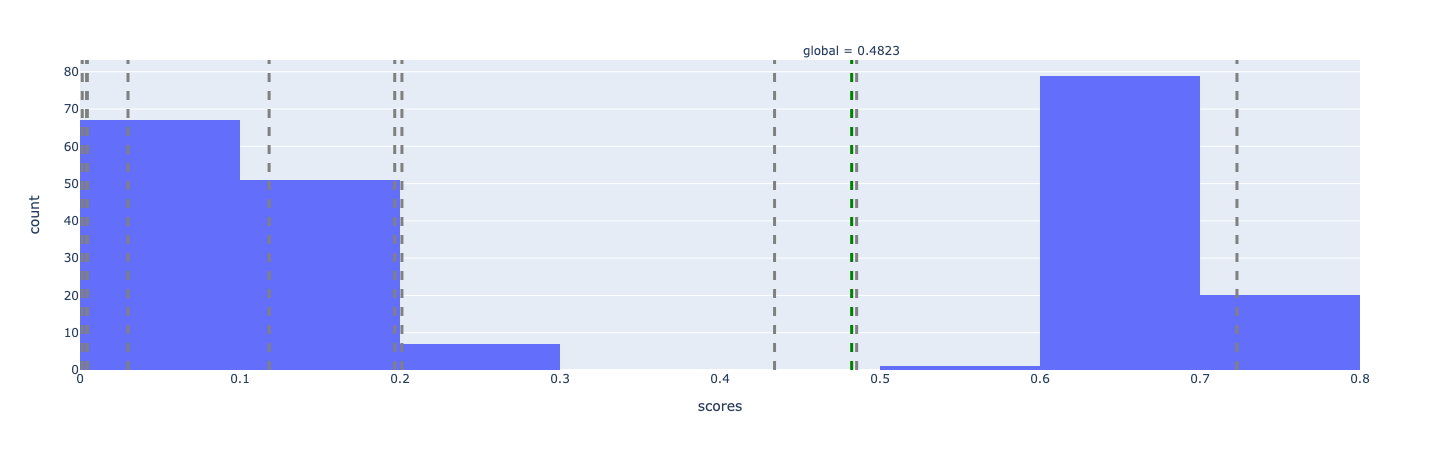

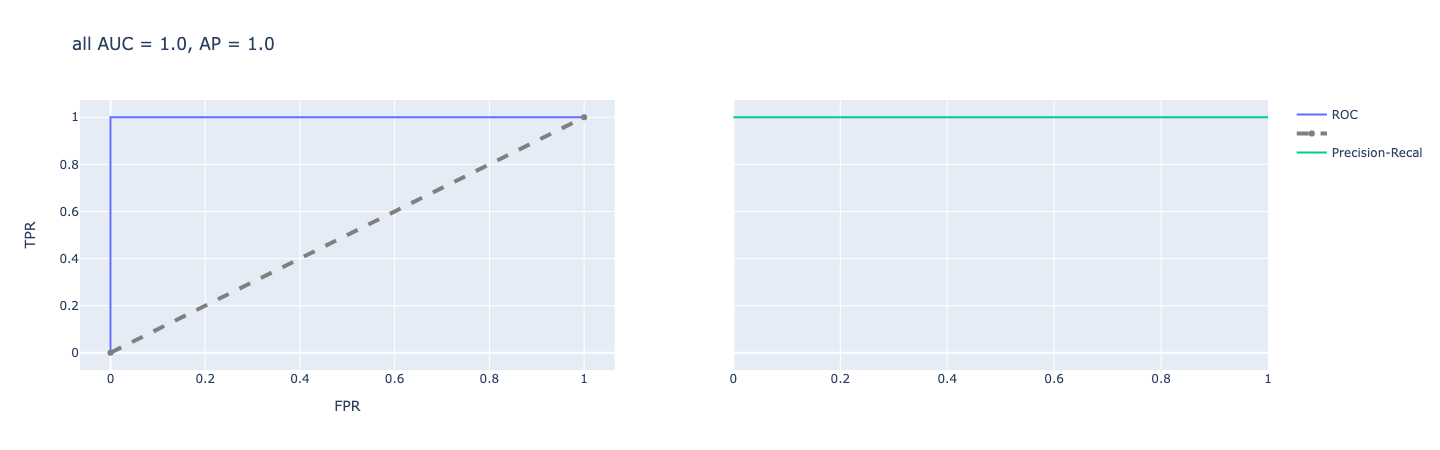


++++++++++++++++++++ gfc ++++++++++++++++++++
   index  scores
0      0    -2.0
1      1    -2.0
2      2    -2.0
3      3    -2.0
4      4    -2.0


/Users/jl102430/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



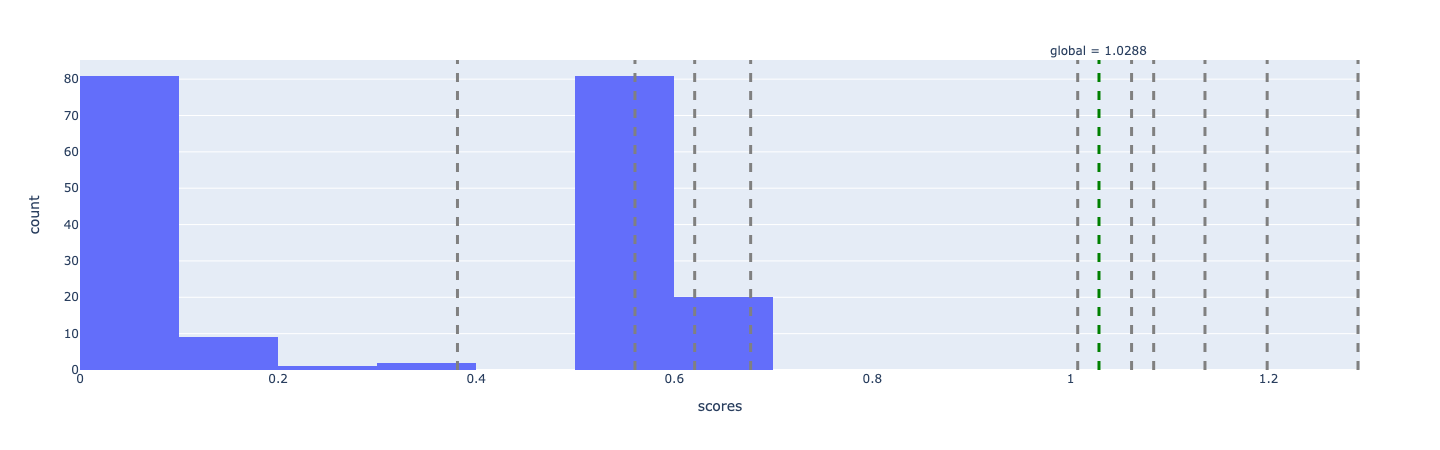

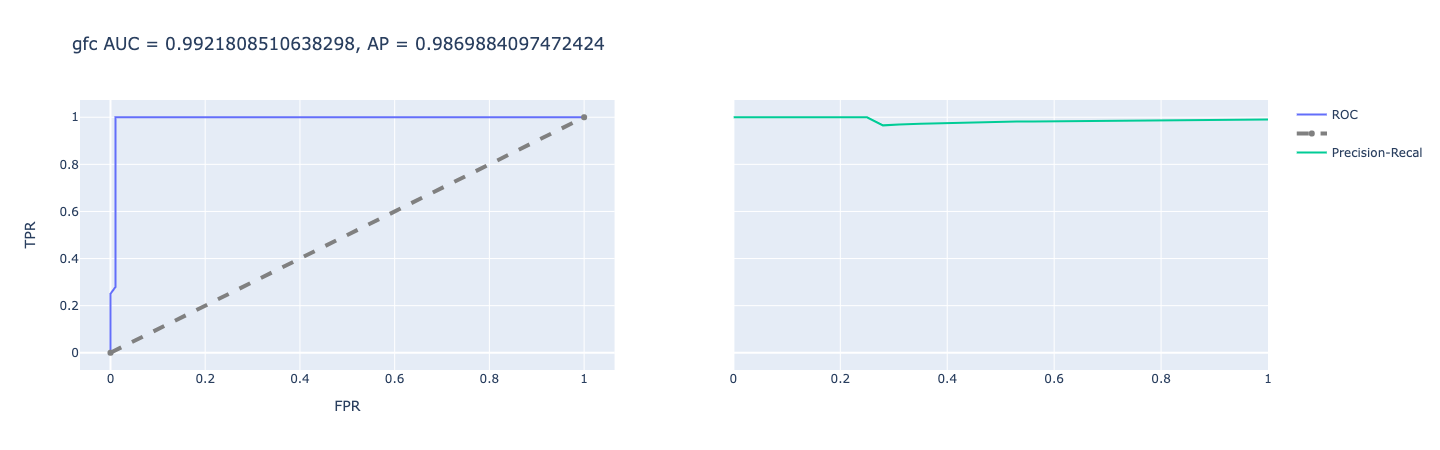


++++++++++++++++++++ ydc ++++++++++++++++++++
   index  scores
0      0    -2.0
1      1    -2.0
2      2    -2.0
3      3    -2.0
4      4    -2.0


/Users/jl102430/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



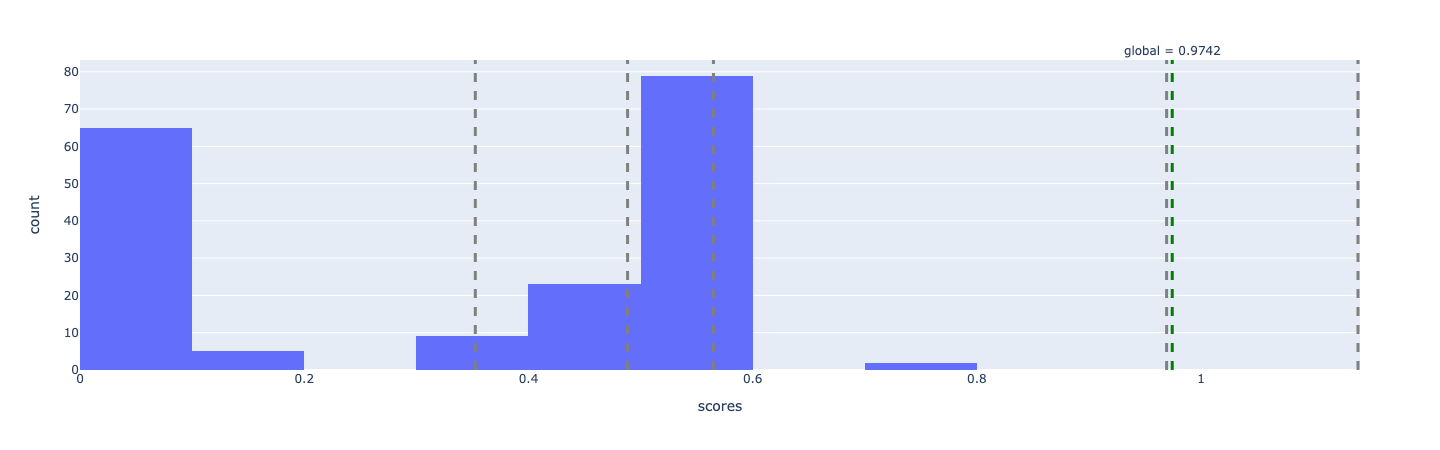

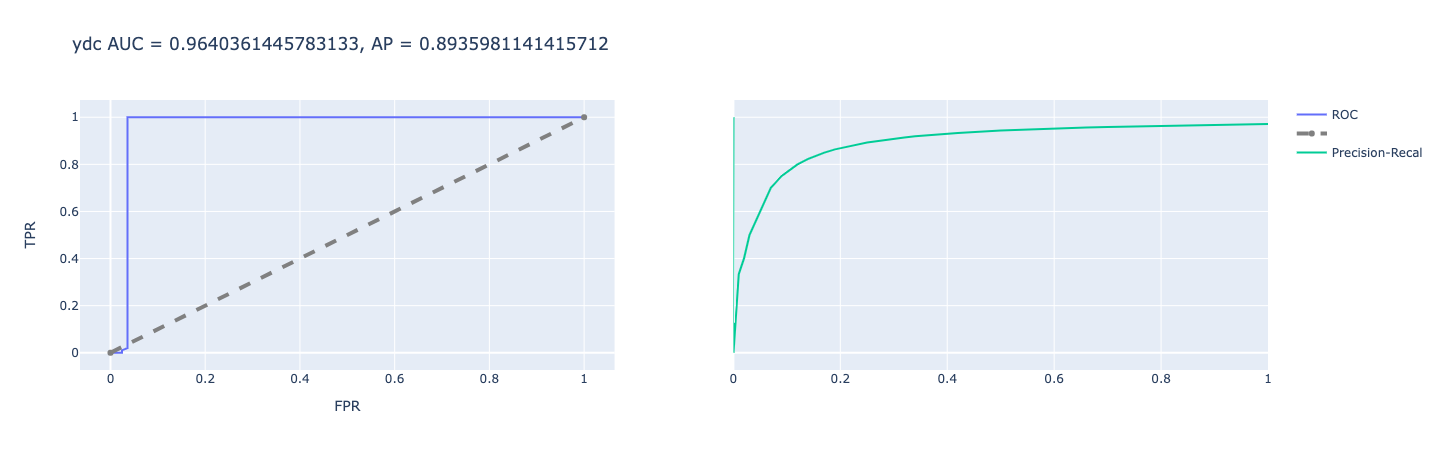

In [36]:
for t, s in [
    ('all', [0.4823,0.4341,0.0300,0.7231,0.1182,0.0014,0.1967,0.0041,0.4854,0.0046,0.2012]),
    ('gfc', [1.0288,1.0840,1.2903,1.1358,0.3811,0.6771,0.5603,1.0073,1.1986,1.0617,0.6206]), 
    ('ydc', [0.9742,0.3526,0.9692,1.1399,0.4884,0.5650])
]:
    show_roc_auc(t, s)

# Streaming Evaluation

In [102]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn import metrics
import plotly.graph_objects as go

In [103]:
stream_anomaly_iterations_path = '../baseline/sbustreamspot-data/anomaly_score_iterations_{}.txt'
stream_cluster_iterations_path = '../baseline/sbustreamspot-data/cluster_map_iterations_{}.txt'

In [108]:
cluster_df = pd.read_csv(stream_cluster_iterations_path.format('all'), sep=' ', header=None).dropna(axis=1)
cluster_df

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0,0,-2,0,-2,-2,-2,0,0,0,...,9,5,-2,7,7,7,9,-2,-2,7
1,0,0,-2,0,-2,-2,-2,0,0,0,...,9,5,-2,7,7,7,9,-2,-2,7
2,0,0,-2,0,-2,-2,-2,0,0,0,...,9,5,-2,7,7,7,9,-2,-2,7
3,0,0,-2,0,-2,-2,-2,0,0,0,...,9,5,-2,7,7,7,9,-2,-2,7
4,0,0,-2,0,-2,-2,-2,0,0,0,...,9,5,-2,7,7,7,9,-2,-2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2478,0,0,-1,0,-1,-1,-1,0,0,0,...,9,5,-1,7,7,7,9,-1,-1,7
2479,0,0,-1,0,-1,-1,-1,0,0,0,...,9,5,-1,7,7,7,9,-1,-1,7
2480,0,0,-1,0,-1,-1,-1,0,0,0,...,9,5,-1,7,7,7,9,-1,-1,7
2481,0,0,-1,0,-1,-1,-1,0,0,0,...,9,5,-1,7,7,7,9,-1,-1,7


In [136]:
data = pd.read_csv(stream_anomaly_iterations_path.format('gfc_train10k'), sep=' ', header=None)

attach_iterations = data[[i for i in range(300,400)]]
attach_iterations.loc[1465]

300    0.640655
301    0.797213
302    0.772669
303    0.711971
304    0.721009
         ...   
395    0.727048
396    0.748268
397    0.766555
398    0.724027
399    0.784924
Name: 1465, Length: 100, dtype: float64

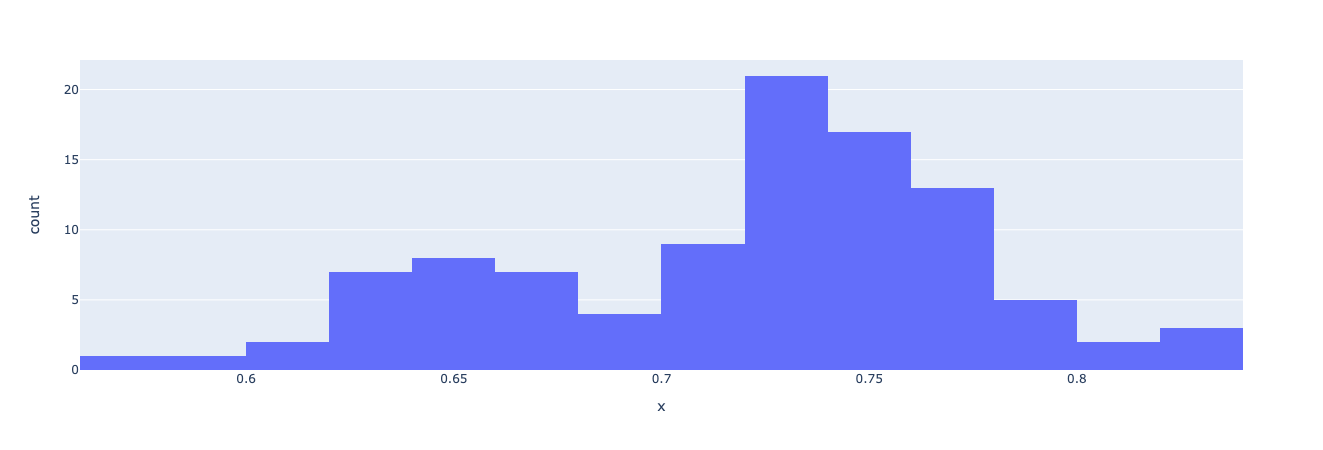

In [137]:
px.histogram(x=attach_iterations.loc[1465])

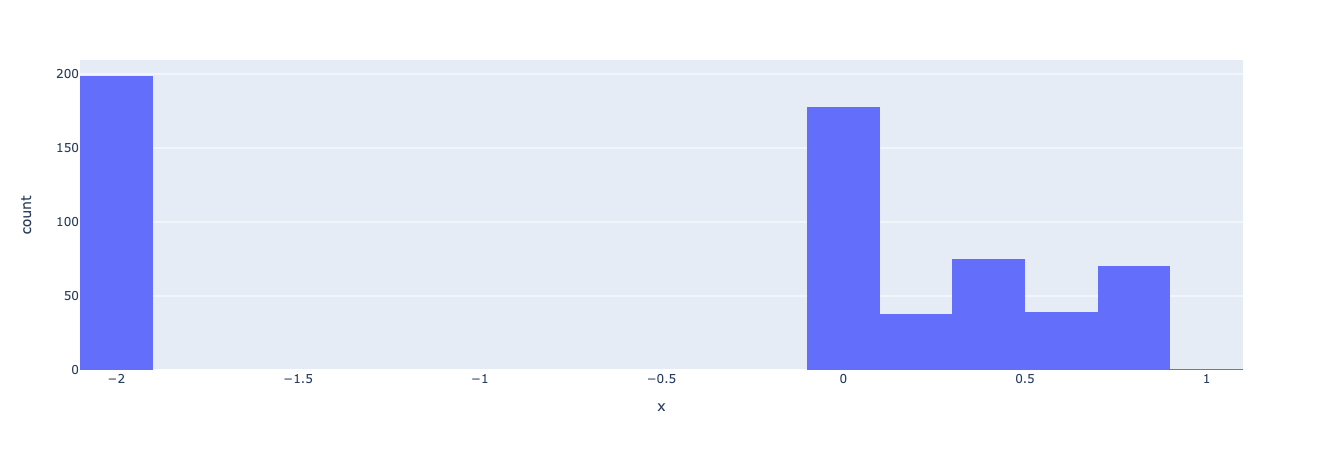

In [135]:
px.histogram(x=data.loc[1465])

In [112]:
cluster_df.loc[0][cluster_df.loc[0]!=-2]

0      0
1      0
3      0
7      0
8      0
      ..
593    7
594    7
595    7
596    9
599    7
Name: 0, Length: 376, dtype: int64

In [122]:
y_truth = np.array([1 if i >= 300 and i <=399 else 0 for i in range(600)])
# print(y_truth)

def calc_accuracy(row):
    # ignore unseen graphs
    seen_graphs = row!=-2
    y_pred = (row == -1).astype(int)
    acc = metrics.accuracy_score(y_truth[seen_graphs], y_pred[seen_graphs])
    return acc

def calc_roc_precision_recall(row):
    y_pred = np.array(row.values)
    assert y_pred.shape == y_truth.shape
    
    # ignore unseen graphs
    seen_graphs = row!=-2
    
    fpr, tpr, thresholds = metrics.roc_curve(y_truth[seen_graphs], y_pred[seen_graphs])
    auc = metrics.auc(fpr, tpr)

    precision, recall, pr_thresholds = metrics.precision_recall_curve(y_truth[seen_graphs], y_pred[seen_graphs])
    ap = metrics.auc(recall, precision)
    
    
    return pd.Series([auc, ap])

roc_ap_df_list = []
for data_type in ['gfc', 'gfc_train10k', 'all']: #['all', 'ydc', 'gfc_cache10k']:
    print(data_type)
    anomaly_df = pd.read_csv(stream_anomaly_iterations_path.format(data_type), sep=' ', header=None).dropna(axis=1)
    streaming_eval = anomaly_df.apply(lambda x: calc_roc_precision_recall(x), axis=1)
    streaming_eval.columns = ['AUC', 'AP']
    streaming_eval['Type'] = data_type
    
    cluster_df = pd.read_csv(stream_cluster_iterations_path.format(data_type), sep=' ', header=None).dropna(axis=1)
    streaming_eval['Accuracy'] = cluster_df.apply(lambda x: calc_accuracy(x), axis=1)
    
    roc_ap_df_list.append(streaming_eval)


streaming_evals = pd.concat(roc_ap_df_list).reset_index().rename(columns={'index':'edge_seen'})
streaming_evals

gfc
gfc_train10k
all


,edge_seen,AUC,AP,Type,Accuracy
0,0,1.000000,1.000000,gfc,0.995192
1,1,0.990916,0.727862,gfc,0.976959
2,2,0.987362,0.481268,gfc,0.976959
3,3,0.989336,0.731632,gfc,0.963134
4,4,0.988152,0.482756,gfc,0.967742
...,...,...,...,...,...
5410,2478,0.876050,0.423919,all,0.791667
5411,2479,0.876030,0.423419,all,0.791667
5412,2480,0.876110,0.425236,all,0.791667
5413,2481,0.876120,0.425425,all,0.791667


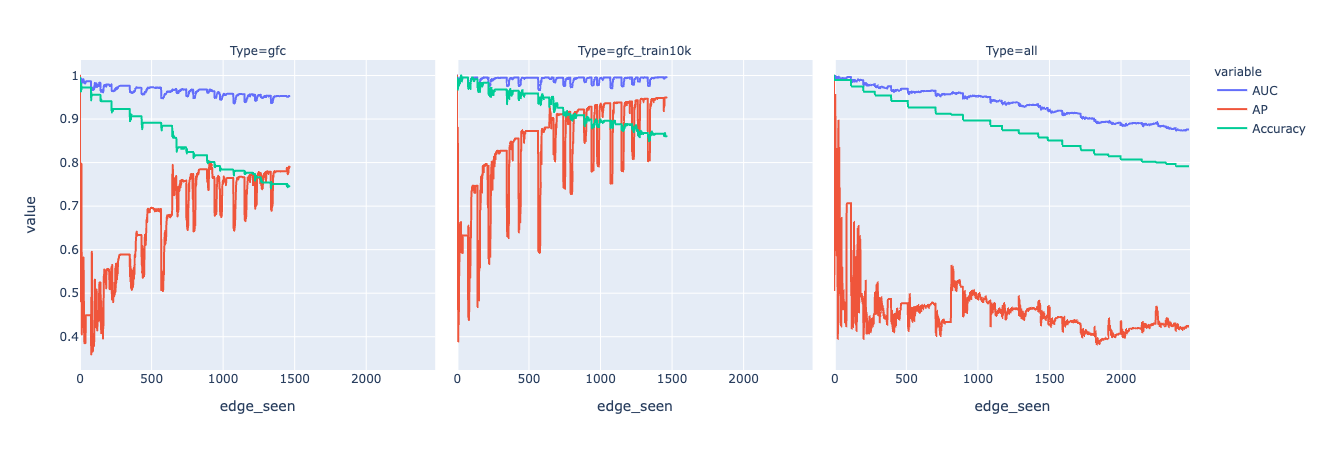

In [123]:
px.line(streaming_evals, x='edge_seen', y=['AUC', 'AP', 'Accuracy'], facet_col='Type')